In [13]:
import os
import glob
import matplotlib.pyplot as plt
from multiprocessing import Pool
%matplotlib inline

In [14]:
cluster_support = 100 # This puts a threshold on clusters to select. Select clusters with support >= given number.
number_of_workers = 12

cluster_files = glob.glob("../data/cluster_results/cid_cluster*.txt")
cid_smiles = {int(entry.split()[0]):entry.split()[1] for entry in open("../data/cid_smiles_sanitized_canonical.txt","r").readlines()}

In [15]:
def read_cluster_file(input_file):
    # Opening and reading files
    with open(input_file,"r") as f:
        cid_cluster = {}
        for entry in f.readlines():
            cid_cluster[int(entry.split()[0])] = int(entry.split()[1])
    return cid_cluster

def plot_frequency_histogram(cluster_dict):    
    cluster_lower_threshold = cluster_support
    cluster_cids_all = {cluster_id:[] for cluster_id in list(map(int,set(list(cluster_dict.values()))))}
    for cid in cluster_dict:
        cluster_cids_all[cluster_dict[cid]].append(cid)

    cluster_cids = {}
    for cluster in cluster_cids_all:
        if len(cluster_cids_all[cluster]) >= cluster_lower_threshold:
            cluster_cids[cluster] = cluster_cids_all[cluster]

    cluster_count = list(cluster_dict.values())
    
    print ("Red line shows the support of " + str(cluster_support))
    # Cluster frequency distribution
    x = cluster_count
    plt.hist(x, density=False, bins=100)  # density=False would make counts
    plt.ylabel('Support')
    plt.xlabel('Cluster number');
    plt.axhline(y=cluster_support, color='r', linestyle='-')
    plt.show()

In [16]:
cid_cluster_all = {}
for files in cluster_files:
    cid_cluster_all[files.split("_")[-1][:-4]] = read_cluster_file(files) 

Plot showing support on each clusters. Cluster number on the x-axis and support in the y axis.

Red line shows the support of 100


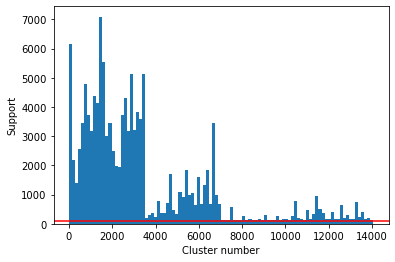

In [17]:

plot_frequency_histogram(cid_cluster_all["0.001"])
#plot_frequency_histogram(cid_cluster_all["0.005"])
#plot_frequency_histogram(cid_cluster_all["0.01"])
#plot_frequency_histogram(cid_cluster_all["0.05"])
#plot_frequency_histogram(cid_cluster_all["0.1"])

In [18]:
# Get data with given cluster_support
# The clusters with given support is chosen and renamed from 0-n
# Outputs cid-cluster data and smiles-cluster data.
# smiles-cluster is further used for training the model
class MakeDataSubset():
    def __init__(self,support,cid_smiles):
        self.support = support
        self.cluster_cid = {}
        self.cid_smiles = cid_smiles
        self.smiles_cluster = {}
        
    def add_data(self,cid_cluster_dict):
        for cid in cid_cluster_dict:
            cluster = cid_cluster_dict[cid]
            if cluster in self.cluster_cid:
                self.cluster_cid[cluster].append(cid)
            else:
                self.cluster_cid[cluster] = [cid]
    
    def apply_threshold(self):
        threshold_dict = {}
        for cluster in self.cluster_cid:
            if len(self.cluster_cid[cluster]) >= self.support:
                threshold_dict[cluster] = self.cluster_cid[cluster]
        self.cluster_cid = threshold_dict
        self.rename_cluster()
        
    def rename_cluster(self): # Renaming the clusters from 0 to n, needed for training DL model
        renamed_data = {}
        reference_changed_clusters = []
        all_old_clusters = list(set(self.cluster_cid.keys()))
        for i,j in zip(range(len(self.cluster_cid)),all_old_clusters):
            renamed_data[i] = self.cluster_cid[j]
            reference_changed_clusters.append([i,j])
            
        self.reference_changed_clusters = reference_changed_clusters
        self.renamed_data = renamed_data
        
    def get_smiles_cluster(self): # Converts CIDs to smiles. Output is smiles cluster
        for cluster in self.renamed_data:
            for cid in self.renamed_data[cluster]:
                try:
                    self.smiles_cluster[self.cid_smiles[cid]] = cluster
                except:
                    pass
    
    def save_data(self,distance_threshold=""): # distance_threshold is the distance used for clustering the data, used for naming the output file
        os.system("mkdir ../data/preprocessed_data")
        with open("../data/preprocessed_data/smiles_cluster_" + str(distance_threshold) + ".txt","w") as f:
            for smiles in self.smiles_cluster:
                f.write(smiles + " " + str(self.smiles_cluster[smiles]) + "\n")
                
        with open("../data/preprocessed_data/cid_cluster_" + str(distance_threshold) + ".txt","w") as f:
            for cluster in self.renamed_data:
                for cid in self.renamed_data[cluster]:
                    f.write(str(cid) + " " + str(cluster) + "\n")
                    
        with open("../data/preprocessed_data/cluster_reference_" + str(distance_threshold) + ".txt","w") as f:
            for renamed_cluster,cluster in self.reference_changed_clusters:
                f.write(str(renamed_cluster) + " " + str(cluster) +"\n")

In [19]:
for distance_threshold in cid_cluster_all:
    subset_data = MakeDataSubset(cluster_support,cid_smiles)
    subset_data.add_data(cid_cluster_all[distance_threshold])
    subset_data.apply_threshold()
    subset_data.get_smiles_cluster()
    subset_data.save_data(distance_threshold)

### Get distance between clusters
<br>
Used for finding distance between chemicals from predictions.

In [20]:
cid_cluster_files =  glob.glob("../data/cluster_results/cid_cluster_*.txt")
def get_cluster_distance(cid_cluster_file):
    os.system("python get_cluster_distance.py " + cid_cluster_file + " " + str(cluster_support))

if __name__ == '__main__':
    with Pool(number_of_workers) as p:
        p.map(get_cluster_distance, cid_cluster_files)
